# 🌊 Machine Learning & Deep Learning for Microbiome and Multi-omics Data
### Training Hands-on Session
**Date:** _2025-10-21_  
**Author:** _Berkay Ekren_  
**Session:** Hands-On

##### ⚙️ Required Tools-Modules
1. Python >= 3.12
2. pandas
3. numpy
4. seaborn
5. matplotlib
6. scikit-learn
7. boruta
8. xgboost
9. lightgbm
10. tensorflow
11. keras (part of tensorflow)


### 📄 Data import for Hands-on Sessions

/run/media/Crucial/berkay/Projects/BIOAQUA_COST_CA22160-20251021


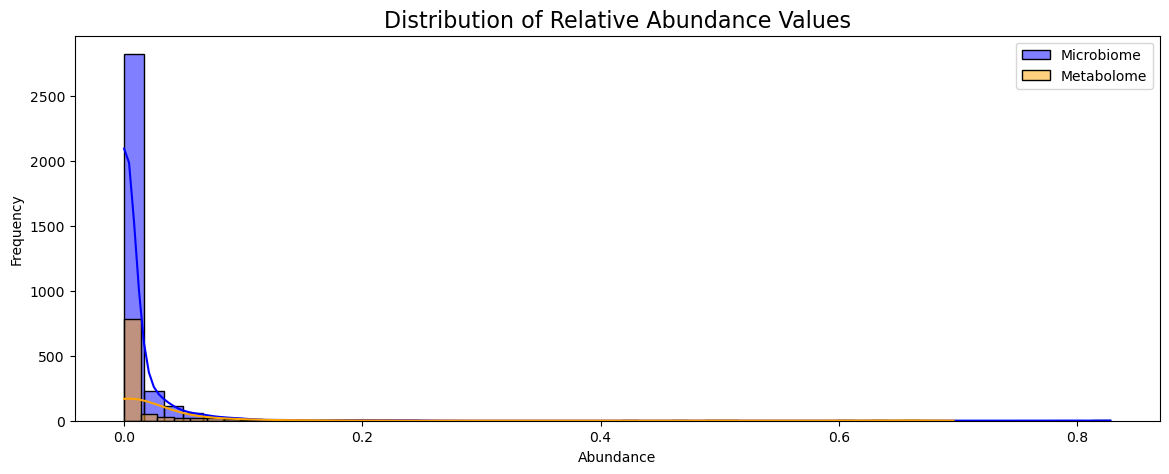

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Comment out to make sure only CPU is used
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print(os.getcwd())

# Get the medatada
metadata_df = pd.read_csv("data/metadata.csv", sep="\t")

# Import data [1]
microbiome_df = pd.read_csv("data/microbiome.csv", sep="\t")
metabolome_df = pd.read_csv("data/metabolome.csv", sep="\t")

# Uncomment the below 2 lines to see the first few rows of the dataframes to see the file structure
#print(microbiome_df.head())
#print(metabolome_df.head())

# Check the distribution of the data with histograms
plt.figure(figsize=(14, 5))
sns.histplot(microbiome_df.iloc[:, 1:].values.flatten(), bins=50, color='blue', label='Microbiome', kde=True)
sns.histplot(metabolome_df.iloc[:, 1:].values.flatten(), bins=50, color='orange', label='Metabolome', kde=True)
plt.title('Distribution of Relative Abundance Values', fontsize=16)
plt.xlabel('Abundance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 🕐 Hands-on Session 1: Machine Learning for Microbiome and Multi-omics Case Studies
### 📋 Objectives:
- Perform **classification** or **regression** using microbiome and omics datasets.
- Identify **biomarkers** relevant to aquaculture species.

### 🔗 Suggested Datasets:
- Microbiome OTU/ASV tables
- Metabolomics or transcriptomics profiles
- Aquaculture phenotype or environmental metadata

### 🧰 Tasks:
1. Load and preprocess data
2. Explore dataset (summary statistics, visualization)
3. Early integration - Late integration methods
4. Apply ML models (e.g., Random Forest, SVM, Gradient Boosting)
5. Evaluate model performances
6. Identify potential biomarkers (feature importance, SHAP, etc.)

In [ ]:
# Import necessary libraries, uncomment as needed for regression tasks
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from sklearn.model_selection import GridSearchCV, StratifiedKFold #, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier #, RandomForestRegressor
from sklearn.svm import SVC #, SVR
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay
# from sklearn.metrics import mean_squared_error, r2_score

#### 🧬 Early integration in machine learning: Concatanate features before modelling

In [ ]:
print("--- Strategy 1: Early Integration ---")

# 1. Set the first column as the index for each dataframe
microbiome_features = microbiome_df.set_index(microbiome_df.columns[0])
metabolome_features = metabolome_df.set_index(metabolome_df.columns[0])

# 2. Transpose the dataframes so that rows are samples and columns are features
X_microbiome = microbiome_features.T
X_metabolome = metabolome_features.T

# 3. Concatenate the dataframes horizontally (axis=1) to create a single feature matrix.
# This aligns the data by sample ID (the index).
early_integration_df = pd.concat([X_microbiome, X_metabolome], axis=1)

print("Shape of Microbiome data (samples, features):", X_microbiome.shape)
print("Shape of Metabolome data (samples, features):", X_metabolome.shape)
print("Shape of combined data for Early Integration:", early_integration_df.shape)

print("\n Early Integration DataFrame Head ")
print(early_integration_df.head(2))

# Create target variables (y) from metadata 
# 4. Set the first column (sample IDs) as the index of the metadata
metadata_indexed = metadata_df.set_index(metadata_df.columns[0])

# 5. Align metadata with the feature dataframe to ensure correct sample order
aligned_metadata = metadata_indexed.reindex(early_integration_df.index)

# 6. Create the classification target from the 'sampling_site' column
# We use factorize to convert site names (e.g., 'SiteA', 'SiteB') into numbers (0, 1)
y_classification, class_labels = pd.factorize(aligned_metadata[aligned_metadata.columns[1]])
print(f"\nClassification target created from column: '{aligned_metadata.columns[1 ]}'")
print(f"Classes found: {class_labels.tolist()}")

##### Split the data into training and testing sets

In [ ]:
# Split the data into training and testing sets
print("\n--- Data splitting for testing and training... ---")


# For regression, we'll use the factorized labels as a placeholder. In practice, replace this with a real continuous variable.
y_regression = y_classification

# Split data for classification task
X_train_early_c, X_test_early_c, y_train_c, y_test_c = train_test_split(
    early_integration_df, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)
# Split data for regression task
X_train_early_r, X_test_early_r, y_train_r, y_test_r = train_test_split(
    early_integration_df, y_regression, test_size=0.2, random_state=42
)

# Display the shapes of the resulting datasets
print("\nShapes of the datasets after splitting:")
print("Classification Task:")
print("X_train_early_c:", X_train_early_c.shape, "X_test_early_c:", X_test_early_c.shape)
print("y_train_c:", y_train_c.shape, "y_test_c:", y_test_c.shape)
print("\nRegression Task:")
print("X_train_early_r:", X_train_early_r.shape, "X_test_early_r:", X_test_early_r.shape)
print("y_train_r:", y_train_r.shape, "y_test_r:", y_test_r.shape)

print("\nData successfully split for training and testing.")

##### Random Forest Importance dependent feature selection

In [ ]:
# Random Forest Importance dependent feature selection
print("\n--- Feature Selection using Random Forest Importance ---")

# 1. Define the base estimator for feature selection
# We use a RandomForestClassifier, as its feature_importances_ attribute is what we need.
# Using class_weight='balanced' is good practice for potentially imbalanced datasets.
rf_for_selection = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

# 2. Use SelectFromModel to automatically select features
# This transformer selects features based on an importance threshold.
# By default, it uses the median importance as the threshold, which is a good starting point.
feature_selector = SelectFromModel(estimator=rf_for_selection)

# 3. Fit the selector on the original (pre-Boruta) training data
print("Fitting the feature selector on the training data...")
# We use the 'early_integration' data before any feature selection was applied
feature_selector.fit(X_train_early_c, y_train_c)

# 4. Get the boolean mask of selected features
selected_features_mask_rf = feature_selector.get_support()

# 5. Apply the mask to get the new feature DataFrames
X_train_selected_c = X_train_early_c.loc[:, selected_features_mask_rf]
X_test_selected_c = X_test_early_c.loc[:, selected_features_mask_rf]

# 6. Display the results
print(f"\nOriginal number of features: {X_train_early_c.shape[1]}")
print(f"Number of features selected by Random Forest: {X_train_selected_c.shape[1]}")

print("\nNames of the first 10 selected features:")
print(X_train_selected_c.columns[:10].tolist())

In [ ]:
# Feature Selection using Boruta
print ("\n--- Feature Selection using Boruta ---")

# 1. Define the estimator
# Boruta needs a base estimator that provides feature importances. Random Forest is perfect.
rf_for_boruta = RandomForestClassifier(n_jobs=-1,class_weight='balanced',max_depth=5,random_state=42)

# 2. Define Boruta feature selection method
# n_estimators='auto' will let Boruta decide the number of trees and set verbose to 2 to see the progress
boruta_selector = BorutaPy(estimator=rf_for_boruta,n_estimators='auto',verbose=2, random_state=42)

# 3. Find all relevant features
# Boruta expects numpy arrays, so we use .values
# Note: Boruta can be slow on datasets with many features.
boruta_selector.fit(X_train_early_c.values, y_train_c)

# 4. Select the confirmed AND tentative important features
# With small datasets, it's often useful to include tentative features.
selected_features_mask = boruta_selector.support_ | boruta_selector.support_weak_

X_train_selected_c = X_train_early_c.loc[:, selected_features_mask]
X_test_selected_c = X_test_early_c.loc[:, selected_features_mask]

# For the regression task, we'll use the same selected features for consistency
X_train_selected_r = X_train_early_r.loc[:, selected_features_mask]
X_test_selected_r = X_test_early_r.loc[:, selected_features_mask]

print(f"\nOriginal number of features: {X_train_early_c.shape[1]}")
print(f"Number of features selected by Boruta (Confirmed + Tentative): {X_train_selected_c.shape[1]}")


In [ ]:
# Models for Classification (Early Integration)
# Hyperparameter Tuning with Cross-Validation for Multiple Models 
print("\n--- Finding Best Model and Hyperparameters with GridSearchCV ---")

# Define the models and their parameter grids
# Calculate scale_pos_weight for imbalanced datasets
scale_pos_weight_value = (len(y_train_c) - sum(y_train_c)) / sum(y_train_c)
y_train_c = y_train_c.astype(int)
y_test_c = y_test_c.astype(int)

# Models for the main loop (XGBoost is now excluded)
models = {
    'LogisticRegression': LogisticRegression(random_state=42,
                                             max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42,
               probability=True),
    'LightGBM': lgb.LGBMClassifier(random_state=42,
                                   verbose=-1), # verbose=-1 silences LGBM warnings
    'XGBoost': xgb.XGBClassifier(base_score=np.sum(y_train_c == 0)/len(y_train_c),
                                 objective='binary:logistic',
                                 booster='gbtree',
                                 tree_method='hist',
                                 random_state=42,
                                 scale_pos_weight=scale_pos_weight_value)
}

param_grids = {
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],
        'solver': ['liblinear'],
        'class_weight': ['balanced']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 75, 100, 150],
        'max_depth': [2, 3, 5, 10],
        'min_samples_leaf': [1, 3],
        'class_weight': ['balanced']
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10, 50, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear'],
        'class_weight': ['balanced']
    },
    'LightGBM': {
        'n_estimators': [50, 75, 100, 150],
        'max_depth': [2, 3, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'class_weight': ['balanced'],
        'num_leaves': [7, 15, 31],
        'min_child_samples': [1, 2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 75, 100, 150],
        'learning_rate': [0.001, 0.01, 0.1, 0.5],
        'gamma': [0, 0.1, 0.5],
        'max_depth': [3, 5],
        'subsample': [0.5, 0.7, 1.0],
        'colsample_bytree': [0.5, 0.7, 1.0]
    }
}

# Set up the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

best_score = -1
best_model_name = ""
best_estimator = None

# Loop through the models
for name, model in models.items():
    print(f"\n Tuning {name} ")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=0)
    grid_search.fit(X_train_selected_c, y_train_c)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validated AUC score: {grid_search.best_score_:.4f}")
        
    best_model = grid_search.best_estimator_
    y_pred_final = best_model.predict(X_test_selected_c)
    y_proba_final = best_model.predict_proba(X_test_selected_c)[:, 1]
    
    # Plot Confusion Matrix, AUROC, and Feature Importance Side-by-Side
    fig, axes = plt.subplots(1, 3, figsize=(14.4, 4))

    # Plot 1: Confusion Matrix
    cm = confusion_matrix(y_test_c, y_pred_final)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
    axes[0].set_title(f'Confusion Matrix for {name}')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Plot 2: ROC Curve
    RocCurveDisplay.from_predictions(y_test_c, y_proba_final, ax=axes[1])
    axes[1].set_title(f'ROC Curve for {name}')
    
    # Plot 3: Feature Importance
    importances = None
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importances = best_model.coef_[0]

    if importances is not None:
        feature_names = X_train_selected_c.columns
        forest_importances = pd.Series(importances, index=feature_names)
        top_importances = forest_importances.abs().nlargest(15)
        
        top_importances.sort_values(ascending=True).plot.barh(ax=axes[2])
        axes[2].set_title(f'Top 15 Feature Importances for {name}')
        axes[2].set_xlabel('Importance')
    else:
        axes[2].text(0.5, 0.5, 'Feature importances not available', ha='center', va='center')
        axes[2].set_title(f'Feature Importances for {name}')
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()
    
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model_name = name
        best_estimator = grid_search.best_estimator_

# Evaluate the Overall Best Model Found
if best_estimator is not None:
    print(f"\n Champion Model: {best_model_name} ")
    print(f"Best CV AUC: {best_score:.4f}")

    # Evaluate the final, champion model on the held-out test set
    y_pred_final = best_estimator.predict(X_test_selected_c)
    y_proba_final = best_estimator.predict_proba(X_test_selected_c)[:, 1]

    final_accuracy = accuracy_score(y_test_c, y_pred_final)
    final_auc = roc_auc_score(y_test_c, y_proba_final)

    print("\nPerformance of Champion Model on Test Set:")
    print(f"  Accuracy: {final_accuracy:.4f}")
    print(f"  AUC: {final_auc:.4f}")

    print("\nClassification Report on Test Set:")
    print(classification_report(y_test_c, y_pred_final))

else:
    print("\nCould not determine a best model due to errors during tuning.")

#### 🧬 Late Integration: Train models separately, then combine predictions (Decision-Level)

In [ ]:
print("\n--- Strategy 2: Late Integration Data Splitting ---")

# Create training and test dataframes for microbiome and metabolome raw data
microbiome_features = microbiome_df.set_index(microbiome_df.columns[0])
metabolome_features = metabolome_df.set_index(metabolome_df.columns[0])

# Transpose the dataframes so that rows are samples and columns are features
X_microbiome = microbiome_features.T
X_metabolome = metabolome_features.T

# Create target variables (y) from metadata
metadata_indexed = metadata_df.set_index(metadata_df.columns[0])

# Align metadata with the feature dataframe to ensure correct sample order
aligned_metadata = metadata_indexed.reindex(X_microbiome.index)

# Create the classification target from the 'sampling_site' column
y_classification, class_labels = pd.factorize(aligned_metadata[aligned_metadata.columns[1]])
print(f"\nClassification target created from column: '{aligned_metadata.columns[1 ]}'")
print(f"Classes found: {class_labels.tolist()}")

# Split microbiome data
X_micro_train, X_micro_test, y_train_late, y_test_late = train_test_split(
    X_microbiome, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Split metabolome data using the same indices from the first split
# We can achieve this by splitting the metabolome data with the same parameters.
X_metab_train, X_metab_test, _, _ = train_test_split(
    X_metabolome, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Display the shapes of the resulting datasets
print("\n Shapes of the datasets for Late Integration ")
print("Microbiome Data:")
print("X_micro_train:", X_micro_train.shape, "| X_micro_test:", X_micro_test.shape)
print("\nMetabolome Data:")
print("X_metab_train:", X_metab_train.shape, "| X_metab_test:", X_metab_test.shape)
print("\nTarget Variable:")
print("y_train_late:", y_train_late.shape, "| y_test_late:", y_test_late.shape)

print("\nData successfully split for late integration.")


In [ ]:
# Apply feature selection with Random Forest Importance for Late Integration datasets
print("\n--- Feature Selection using Random Forest Importance for Late Integration ---")

# Define a function to run RF-based feature selection, as we'll do it for each dataset
def run_rf_selection(X_train, y_train, data_name=""):
    print(f"\nStarting Random Forest feature selection for {data_name} data...")
    # 1. Define the base estimator
    rf_estimator = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
    
    # 2. Use SelectFromModel to automatically select features based on median importance
    feature_selector = SelectFromModel(estimator=rf_estimator, threshold='median')
    
    # 3. Fit the selector on the training data
    feature_selector.fit(X_train, y_train)
    
    # 4. Get the boolean mask of selected features
    selected_mask = feature_selector.get_support()
    
    print(f"Random Forest selected {sum(selected_mask)} features from {X_train.shape[1]} for {data_name} data.")
    
    return selected_mask

# Run RF Selection on Microbiome Data
rf_mask_micro = run_rf_selection(X_micro_train, y_train_late, "Microbiome")
X_micro_train_selected = X_micro_train.loc[:, rf_mask_micro]
X_micro_test_selected = X_micro_test.loc[:, rf_mask_micro]

# Run RF Selection on Metabolome Data
rf_mask_metab = run_rf_selection(X_metab_train, y_train_late, "Metabolome")
X_metab_train_selected = X_metab_train.loc[:, rf_mask_metab]
X_metab_test_selected = X_metab_test.loc[:, rf_mask_metab]

print("\n Shapes after Random Forest Feature Selection ")
print("Microbiome Train:", X_micro_train_selected.shape, "| Microbiome Test:", X_micro_test_selected.shape)
print("Metabolome Train:", X_metab_train_selected.shape, "| Metabolome Test:", X_metab_test_selected.shape)


In [ ]:
# Apply feature selection with Boruta for Late Integration datasets
print("\n--- Feature Selection using Boruta for Late Integration ---")

# Define a function to run Boruta, as we'll do it for each dataset
def run_boruta_selection(X_train, y_train, data_name=""):
    print(f"\nStarting Boruta for {data_name} data...")
    # Define the estimator
    rf_estimator = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
    
    # Define Boruta feature selection method
    boruta_selector = BorutaPy(
        estimator=rf_estimator,
        n_estimators='auto',
        verbose=0, # Set to 2 to see progress
        random_state=42
    )
    
    # Find all relevant features
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the mask for selected features (confirmed + tentative)
    selected_mask = boruta_selector.support_ | boruta_selector.support_weak_
    
    print(f"Boruta selected {sum(selected_mask)} features from {X_train.shape[1]} for {data_name} data.")
    
    return selected_mask

# Run Boruta on Microbiome Data
boruta_mask_micro = run_boruta_selection(X_micro_train, y_train_late, "Microbiome")
X_micro_train_selected = X_micro_train.loc[:, boruta_mask_micro]
X_micro_test_selected = X_micro_test.loc[:, boruta_mask_micro]

# Run Boruta on Metabolome Data
boruta_mask_metab = run_boruta_selection(X_metab_train, y_train_late, "Metabolome")
X_metab_train_selected = X_metab_train.loc[:, boruta_mask_metab]
X_metab_test_selected = X_metab_test.loc[:, boruta_mask_metab]

print("\n Shapes after Boruta Feature Selection ")
print("Microbiome Train:", X_micro_train_selected.shape, "| Microbiome Test:", X_micro_test_selected.shape)
print("Metabolome Train:", X_metab_train_selected.shape, "| Metabolome Test:", X_metab_test_selected.shape)

# The selected dataframes (e.g., X_micro_train_selected) are now ready for the next step.


In [ ]:
# Strategy 2: Late Integration (Decision-Level) with Feature-Selected Data
print("\n--- Late Integration (Decision-Level) with Feature-Selected Data and GridSearchCV ---")

# We will use the data selected by Boruta. To use RF-selected data, change the dictionaries below.
datasets_train = {'micro': X_micro_train_selected, 'metab': X_metab_train_selected}
datasets_test = {'micro': X_micro_test_selected, 'metab': X_metab_test_selected}

scale_pos_weight_value = (len(y_train_late) - sum(y_train_late)) / sum(y_train_late)

# Define the base models to be used for each dataset
base_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000,
                                             random_state=42),
    'SVC': SVC(probability=True,
               random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42,
                                   verbose=-1),
    'XGBoost': xgb.XGBClassifier(objective='binary:logistic',
                                 booster='gbtree',
                                 tree_method='hist',
                                 random_state=42)
}

param_grids_late = {
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],
        'solver': ['liblinear'],
        'class_weight': ['balanced']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 75, 100, 150],
        'max_depth': [2, 3, 5, 10],
        'min_samples_leaf': [1, 3],
        'class_weight': ['balanced']
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10, 50, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear'],
        'class_weight': ['balanced']
    },
    'LightGBM': {
        'n_estimators': [50, 75, 100, 150],
        'max_depth': [2, 3, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'class_weight': ['balanced'],
        'num_leaves': [7, 15, 31],
        'min_child_samples': [1, 2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 75, 100, 150],
        'learning_rate': [0.001, 0.01, 0.1, 0.5],
        'gamma': [0, 0.1, 0.5],
        'max_depth': [3, 5],
        'subsample': [0.5, 0.7, 1.0],
        'colsample_bytree': [0.5, 0.7, 1.0]
    }
}

meta_features_train = []
meta_features_test = []
model_performance = {}

# Set up the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Train base models with GridSearchCV, evaluate them, and generate predictions for the meta-model
for name, model in base_models.items():
    print(f"\n Evaluating Base Model: {name} ")
    for data_type, X_train_curr in datasets_train.items():
        print(f"Tuning and training on {data_type} data...")
        
        X_test_curr = datasets_test[data_type]
        
        # Tune hyperparameters for the base model
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids_late[name], cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=0)
        grid_search.fit(X_train_curr, y_train_late)
        best_model = grid_search.best_estimator_
        
        print(f"  Best params for {name} on {data_type}: {grid_search.best_params_}")
        
        # Fit the best model on the full training data to evaluate it
        best_model.fit(X_train_curr, y_train_late)
        y_proba = best_model.predict_proba(X_test_curr)[:, 1]
        
        # Evaluate and store performance
        auc = roc_auc_score(y_test_late, y_proba)
        model_performance[f"{name}_{data_type}"] = auc
        print(f"  AUC for {name} on {data_type}: {auc:.4f}")

        # Plot Feature Importance for the base model
        fig, ax = plt.subplots(1, 1, figsize=(7.2, 4))
        importances = None
        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_
        elif hasattr(best_model, 'coef_'):
            importances = best_model.coef_[0]

        if importances is not None:
            feature_names = X_train_curr.columns
            base_importances = pd.Series(importances, index=feature_names)
            top_importances = base_importances.abs().nlargest(15)
            
            top_importances.sort_values(ascending=True).plot.barh(ax=ax)
            ax.set_title(f'Top 15 Feature Importances for {name} on {data_type}')
            ax.set_xlabel('Importance')
        else:
            ax.text(0.5, 0.5, 'Feature importances not available', ha='center', va='center')
            ax.set_title(f'Feature Importances for {name} on {data_type}')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

        # Generate cross-validated predictions for the training set (for meta-model)
        train_preds = cross_val_predict(best_model, X_train_curr, y_train_late, cv=cv_strategy, method='predict_proba')[:, 1]
        meta_features_train.append(train_preds)
        
        # Predict on the test set for the meta-model
        meta_features_test.append(y_proba)

# Identify the best-performing base model
best_base_model_key = max(model_performance, key=model_performance.get)
print(f"\n Best Performing Base Model Combination: {best_base_model_key} (AUC: {model_performance[best_base_model_key]:.4f}) ")

# Combine predictions into final meta-feature matrices
X_late_train = np.array(meta_features_train).T
X_late_test = np.array(meta_features_test).T

print(f"\nShape of the new feature set for the meta-model (train): {X_late_train.shape}")
print(f"Shape of the new feature set for the meta-model (test): {X_late_test.shape}")

# Train and evaluate the final meta-models using all base model types with GridSearchCV
print("\n Training and evaluating the final meta-models with GridSearchCV ")
meta_feature_names = [f"{name}_{data_type}" for name in base_models.keys() for data_type in datasets_train.keys()]

for name, model in base_models.items():
    print(f"\n Meta-Model: {name} ")
    
    # Tune the meta-model
    meta_grid_search = GridSearchCV(estimator=model, param_grid=param_grids_late[name], cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=0)
    meta_grid_search.fit(X_late_train, y_train_late)
    best_meta_model = meta_grid_search.best_estimator_
    
    print(f"  Best params for {name} meta-model: {meta_grid_search.best_params_}")

    y_pred_meta = best_meta_model.predict(X_late_test)
    y_proba_meta = best_meta_model.predict_proba(X_late_test)[:, 1]

    accuracy_meta = accuracy_score(y_test_late, y_pred_meta)
    auc_meta = roc_auc_score(y_test_late, y_proba_meta)

    print("\n Performance of Late Integration (Decision-Level) Model ")
    print(f"  Accuracy: {accuracy_meta:.4f}")
    print(f"  AUC: {auc_meta:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test_late, y_pred_meta, target_names=class_labels, zero_division=0))

    # Plot confusion matrix, AUROC, and Feature Importance for the final meta-model
    fig, axes = plt.subplots(1, 3, figsize=(14.4, 4))

    # Confusion Matrix
    cm_meta = confusion_matrix(y_test_late, y_pred_meta)
    sns.heatmap(cm_meta, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
    axes[0].set_title(f'Confusion Matrix for {name} Meta-Model')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test_late, y_proba_meta, ax=axes[1])
    axes[1].set_title(f'ROC Curve for {name} Meta-Model')

    # Feature Importance
    importances = None
    if hasattr(best_meta_model, 'feature_importances_'):
        importances = best_meta_model.feature_importances_
    elif hasattr(best_meta_model, 'coef_'):
        importances = best_meta_model.coef_[0]

    if importances is not None:
        meta_importances = pd.Series(importances, index=meta_feature_names)
        top_importances = meta_importances.abs().nlargest(15)
        
        top_importances.sort_values(ascending=True).plot.barh(ax=axes[2])
        axes[2].set_title('Top 15 Meta-Feature Importances')
        axes[2].set_xlabel('Importance')
    else:
        axes[2].text(0.5, 0.5, 'Feature importances not available', ha='center', va='center')
        axes[2].set_title(f'Feature Importances for {name}')
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()

## 🕐 Hands-on session 2: Deep Learning for Multi-omics Data
### 📋 Objectives:
- Build **deep learning** models to predict outcomes from multi-omics datasets.
- Combine datasets (multi-view or multimodal learning).
- Evaluate performance and interpretability.

### 🧬 Suggested Frameworks:
- TensorFlow / Keras
- PyTorch / PyTorch Lightning

### 🧰 Tasks:
1. Prepare multi-omics datasets for modeling
2. Define and train deep learning models
3. Evaluate performance (accuracy, loss curves, confusion matrix)
4. Interpret model predictions

In [20]:
# import required libraries
import random
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

##### Create dataset splits

In [12]:
print("\n Data Splitting for Deep Learning ")

# We use the raw, unselected features for the DL model.
microbiome_features = microbiome_df.set_index(microbiome_df.columns[0])
metabolome_features = metabolome_df.set_index(metabolome_df.columns[0])

# Transpose the dataframes so that rows are samples and columns are features
X_microbiome = microbiome_features.T
X_metabolome = metabolome_features.T

metadata_indexed = metadata_df.set_index(metadata_df.columns[0])

# Align metadata with the feature dataframe to ensure correct sample order
aligned_metadata = metadata_indexed.reindex(X_microbiome.index)

# Create the classification target from the 'sampling_site' column
y_classification, class_labels = pd.factorize(aligned_metadata[aligned_metadata.columns[1]])

# Step 1: Split into training+validation (80%) and test (20%) sets
X_micro_train_full, X_micro_test, y_train_full, y_test_dl = train_test_split(
    X_microbiome, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)
X_metab_train_full, X_metab_test, _, _ = train_test_split(
    X_metabolome, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Step 2: Split the full training set into a final training set and a validation set
# This results in ~60% train, ~20% validation, 20% test of the original data
X_micro_train, X_micro_val, y_train_dl, y_val_dl = train_test_split(
    X_micro_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)
X_metab_train, X_metab_val, _, _ = train_test_split(
    X_metab_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)


# Display the shapes of the resulting datasets
print("\n--- Shapes of the datasets for Deep Learning ---")
print("Microbiome Data:")
print("Train:", X_micro_train.shape, "| Validation:", X_micro_val.shape, "| Test:", X_micro_test.shape)
print("\nMetabolome Data:")
print("Train:", X_metab_train.shape, "| Validation:", X_metab_val.shape, "| Test:", X_metab_test.shape)
print("\nTarget Variable:")
print("Train:", y_train_dl.shape, "| Validation:", y_val_dl.shape, "| Test:", y_test_dl.shape)

print("\nData successfully split for Deep Learning.")


 Data Splitting for Deep Learning 

--- Shapes of the datasets for Deep Learning ---
Microbiome Data:
Train: (21, 95) | Validation: (7, 95) | Test: (7, 95)

Metabolome Data:
Train: (21, 29) | Validation: (7, 29) | Test: (7, 29)

Target Variable:
Train: (21,) | Validation: (7,) | Test: (7,)

Data successfully split for Deep Learning.


##### Apply feature selection with Random Forest

In [13]:
# Apply feature selection with SelectFromModel
print("\n--- Feature Selection using SelectFromModel for Deep Learning ---")

# Define a function to run the selection
def run_rf_selection(X_train, y_train, data_name=""):
    print(f"\nStarting RF feature selection for {data_name} data...")
    # Using a simple RF classifier to get feature importances
    rf_estimator = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
    
    # Select features where importance is greater than the median
    # This is a good balance, not too aggressive.
    feature_selector = SelectFromModel(estimator=rf_estimator, threshold='median')
    
    # Fit the selector
    feature_selector.fit(X_train, y_train)
    
    selected_mask = feature_selector.get_support()
    
    print(f"SelectFromModel selected {sum(selected_mask)} features from {X_train.shape[1]} for {data_name} data.")
    
    return selected_mask

# Run Selection on Microbiome Data
rf_mask_micro = run_rf_selection(X_micro_train, y_train_dl, "Microbiome")
X_micro_train_selected = X_micro_train.loc[:, rf_mask_micro]
X_micro_val_selected = X_micro_val.loc[:, rf_mask_micro]
X_micro_test_selected = X_micro_test.loc[:, rf_mask_micro]

# Run Selection on Metabolome Data
rf_mask_metab = run_rf_selection(X_metab_train, y_train_dl, "Metabolome")
X_metab_train_selected = X_metab_train.loc[:, rf_mask_metab]
X_metab_val_selected = X_metab_val.loc[:, rf_mask_metab]
X_metab_test_selected = X_metab_test.loc[:, rf_mask_metab]

print("\n Shapes after SelectFromModel Feature Selection ")
print("Microbiome Train:", X_micro_train_selected.shape, "| Validation:", X_micro_val_selected.shape, "| Test:", X_micro_test_selected.shape)
print("Metabolome Train:", X_metab_train_selected.shape, "| Validation:", X_metab_val_selected.shape, "| Test:", X_metab_test_selected.shape)


--- Feature Selection using SelectFromModel for Deep Learning ---

Starting RF feature selection for Microbiome data...
SelectFromModel selected 48 features from 95 for Microbiome data.

Starting RF feature selection for Metabolome data...
SelectFromModel selected 15 features from 29 for Metabolome data.

 Shapes after SelectFromModel Feature Selection 
Microbiome Train: (21, 48) | Validation: (7, 48) | Test: (7, 48)
Metabolome Train: (21, 15) | Validation: (7, 15) | Test: (7, 15)
SelectFromModel selected 15 features from 29 for Metabolome data.

 Shapes after SelectFromModel Feature Selection 
Microbiome Train: (21, 48) | Validation: (7, 48) | Test: (7, 48)
Metabolome Train: (21, 15) | Validation: (7, 15) | Test: (7, 15)


##### Apply feature selection with Boruta

In [ ]:
# Apply feature selection with Boruta this can be too sctick for some datasets.
print("\n--- Feature Selection using Boruta for Deep Learning ---")

# Define a function to run Boruta, as we'll do it for each dataset
def run_boruta_selection(X_train, y_train, data_name=""):
    print(f"\nStarting Boruta for {data_name} data...")
    # Define the estimator
    rf_estimator = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
    
    # Define Boruta feature selection method
    boruta_selector = BorutaPy(
        estimator=rf_estimator,
        n_estimators='auto',
        verbose=0, # Set to 2 to see progress
        random_state=42
    )
    
    # Find all relevant features
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the mask for selected features (confirmed + tentative)
    selected_mask = boruta_selector.support_ | boruta_selector.support_weak_
    
    print(f"Boruta selected {sum(selected_mask)} features from {X_train.shape[1]} for {data_name} data.")
    
    return selected_mask

# Run Boruta on Microbiome Data
boruta_mask_micro = run_boruta_selection(X_micro_train, y_train_dl, "Microbiome")
X_micro_train_selected = X_micro_train.loc[:, boruta_mask_micro]
X_micro_val_selected = X_micro_val.loc[:, boruta_mask_micro]
X_micro_test_selected = X_micro_test.loc[:, boruta_mask_micro]

# Run Boruta on Metabolome Data
boruta_mask_metab = run_boruta_selection(X_metab_train, y_train_dl, "Metabolome")
X_metab_train_selected = X_metab_train.loc[:, boruta_mask_metab]
X_metab_val_selected = X_metab_val.loc[:, boruta_mask_metab]
X_metab_test_selected = X_metab_test.loc[:, boruta_mask_metab]

print("\n Shapes after Boruta Feature Selection ")
print("Microbiome Train:", X_micro_train_selected.shape, "| Validation:", X_micro_val_selected.shape, "| Test:", X_micro_test_selected.shape)
print("Metabolome Train:", X_metab_train_selected.shape, "| Validation:", X_metab_val_selected.shape, "| Test:", X_metab_test_selected.shape)

# The selected dataframes are now ready for the next step.


--- Feature Selection using Boruta for Deep Learning ---

Starting Boruta for Microbiome data...
Boruta selected 2 features from 95 for Microbiome data.

Starting Boruta for Metabolome data...
Boruta selected 0 features from 29 for Metabolome data.

 Shapes after Boruta Feature Selection 
Microbiome Train: (21, 2) | Validation: (7, 2) | Test: (7, 2)
Metabolome Train: (21, 0) | Validation: (7, 0) | Test: (7, 0)


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ microbiome_input    │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ metabolome_input    │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 32)        │      1,568 │ microbiome_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 16)        │        256 │ metabolome_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 32)        │          0 │ dense_51[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 16)        │          0 │ dense_52[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 48)        │          0 │ dropout_51[0][0], │
│ (Concatenate)       │                   │            │ dropout_52[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 16)        │        784 │ concatenate_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 16)        │          0 │ dense_53[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         17 │ dropout_53[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,625 (10.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - AUC: 0.5818 - accuracy: 0.5714 - loss: 0.6880 - val_AUC: 0.1667 - val_accuracy: 0.4286 - val_loss: 0.7035
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - AUC: 0.4364 - accuracy: 0.4762 - loss: 0.7075 - val_AUC: 0.2083 - val_accuracy: 0.2857 - val_loss: 0.7032
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - AUC: 0.6909 - accuracy: 0.6667 - loss: 0.6763 - val_AUC: 0.2083 - val_accuracy: 0.2857 - val_loss: 0.7029
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - AUC: 0.6909 - accuracy: 0.6667 - loss: 0.6822 - val_AUC: 0.2083 - val_accuracy: 0.2857 - val_loss: 0.7023
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - AUC: 0.6136 - accuracy: 0.5714 - loss: 0.6825 - val_AUC: 0.2083 - val_accuracy: 0.4286 - val_loss: 0.7019
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - AUC: 0.5409 - accuracy: 0.5714 - loss: 0.6896 - val_AUC: 0.1667 - val_accuracy: 0.4286 - val_loss: 0.7014
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - AU

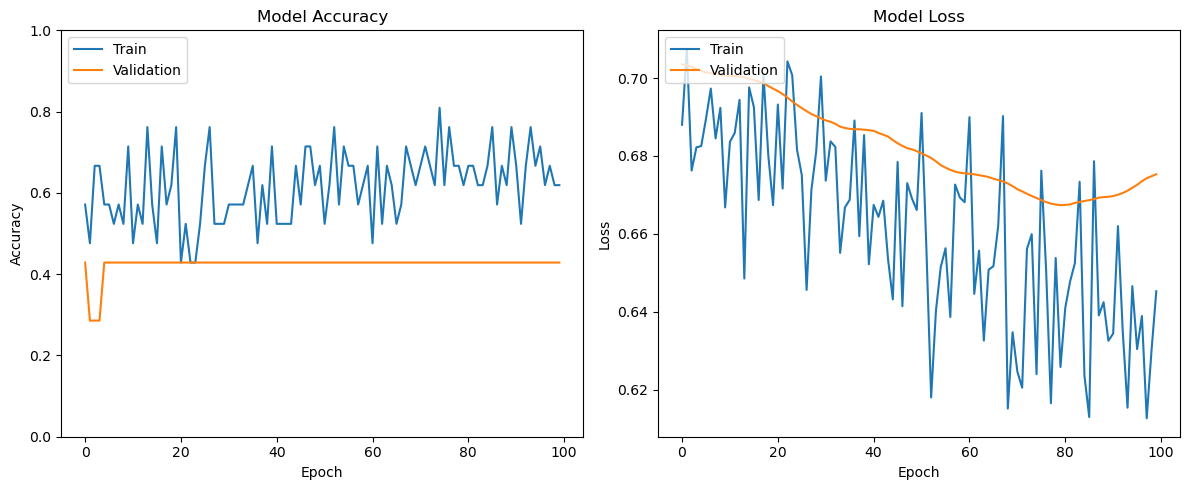

In [ ]:
# Build a Multi-Input Deep Learning Model using Keras Functional API
seed_value = 100

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Define the input layers for each data type
input_micro = Input(shape=(X_micro_train_selected.shape[1],), name='microbiome_input')
input_metab = Input(shape=(X_metab_train_selected.shape[1],), name='metabolome_input')

# Microbiome Branch
x1 = Dense(32, activation='relu')(input_micro)
x1 = Dropout(0.3)(x1)
x1 = Model(inputs=input_micro, outputs=x1)

# Metabolome Branch
x2 = Dense(16, activation='relu')(input_metab)
x2 = Dropout(0.3)(x2)
x2 = Model(inputs=input_metab, outputs=x2)

# Concatenate the branches
combined = Concatenate()([x1.output, x2.output])

# Fully Connected Head
z = Dense(16, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid', name='final_output')(z)

# Create and Compile the Model
optimizer = Adam(learning_rate=0.001)
multi_input_model = Model(inputs=[x1.input, x2.input], outputs=output)

multi_input_model.compile(optimizer=optimizer,
                          loss='binary_crossentropy',
                          metrics=['accuracy', 'AUC'])

# Print the model summary to see the architecture
multi_input_model.summary()

# Train the Model
history = multi_input_model.fit(
    [X_micro_train_selected, X_metab_train_selected],
    y_train_dl,
    epochs=150, # Increased epochs
    batch_size=16, # Increased batch size
    validation_data=([X_micro_val_selected, X_metab_val_selected], y_val_dl),
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)], # Increased patience
    verbose=1
)

# Evaluate the Model on the Test Set 
print("\n Evaluating the multi-input model on the test set ")
loss, accuracy, auc = multi_input_model.evaluate([X_micro_test_selected, X_metab_test_selected], y_test_dl)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

# Plot Training History 
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim([0, 1])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## 🕐 Hands-on 3: Integrated Workflow — From Data to Insights
### 📋 Objectives:
- Build an **end-to-end workflow** from raw data → preprocessing → ML/DL models.
- Combine microbiome, omics, and environmental data.
- Derive interpretable **biological insights** relevant to aquaculture.

### ⚙️ Example Workflow Steps:
1. Raw data QC and normalization
2. Feature selection or dimensionality reduction
3. Model training and validation
4. Post-hoc interpretation and visualization

In [ ]:
# Example: Integrated pipeline pseudocode
# Step 1: Preprocess data
# Step 2: Train model
# Step 3: Evaluate results
# Step 4: Visualize findings

# Placeholder for pipeline code

### 📚 Suggested Reading & Resources
- [QIIME 2 16S Amplicon Pipeline](https://library.qiime2.org/quickstart/amplicon)
- [QIIME 2 - MOSHPIT Whole Metagenome Pipeline](https://library.qiime2.org/quickstart/moshpit)
- [QIIME 2 Machine Learning Plugin](https://docs.qiime2.org/)
- [Meta-CAMP - MetaSUB Whole Metagenome Analysis Pipeline](https://github.com/Meta-CAMP)
- [scikit-learn documentation](https://scikit-learn.org/stable/)
- [IBM Deep Leaning](https://www.ibm.com/think/topics/deep-learning)
- [TensorFlow tutorials](https://www.tensorflow.org/tutorials)
- [PyTorch tutorials](https://pytorch.org/tutorials/)
- Example datasets: [EBI Metagenomics](https://www.ebi.ac.uk/metagenomics/)

**References**
1. Mazzella, V., Dell’Anno, A., Etxebarría, N., González-Gaya, B., Nuzzo, G., Fontana, A., & Núñez-Pons, L. (2024). High microbiome and metabolome diversification in coexisting sponges with different bio-ecological traits. Communications Biology, 7(1), 422.